## Step 7: Normalization of Pan-Cancer Dataset
We perform several normalization steps including total count normalization, log transformation, Scran normalization, and analytic Pearson residuals. This prepares the data for downstream feature selection and dimensionality reduction.


## 7.1 Load Filtered AnnData

We begin by loading the QC-filtered dataset that contains only high-quality cells.


In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext rpy2.ipython

# 📥 Load filtered dataset
adata = sc.read("../../data/pancancer_raw_umi_filtered.h5ad")
print(f"✅ Loaded QC-filtered AnnData object: {adata.shape}")


✅ Loaded QC-filtered AnnData object: (39726, 30314)


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:72: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


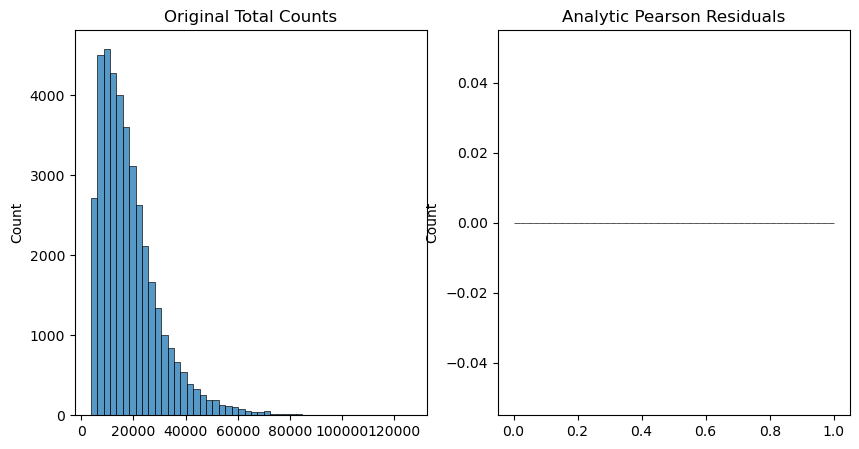

In [ ]:
# 🔬 Pearson residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["pearson_residuals"] = analytic_pearson["X"]

# 📊 Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
residual_values = np.array(adata.layers["analytic_pearson_residuals"]).flatten()
sns.histplot(residual_values, bins=100)axes[1].set_title("Analytic Pearson Residuals")
plt.show()



In [3]:
import pandas as pd

# Pearson residuals matrix
pearson_df = pd.DataFrame(
    adata.layers["pearson_residuals"],
    index=adata.obs_names,
    columns=adata.var_names
)

# Save as parquet
pearson_path = "../../data/processed/pancancer_pearson_residuals.parquet"
pearson_df.to_parquet(pearson_path, engine="pyarrow", compression="snappy")

print(f"✅ Saved Pearson residuals to {pearson_path} | Shape: {pearson_df.shape}")


✅ Saved Pearson residuals to ../../data/processed/pancancer_pearson_residuals.parquet | Shape: (39726, 30314)


## 7.2 Log1p Normalization

We normalize gene expression by total counts and then apply a log(1 + x) transformation. This step helps mitigate technical effects related to sequencing depth.


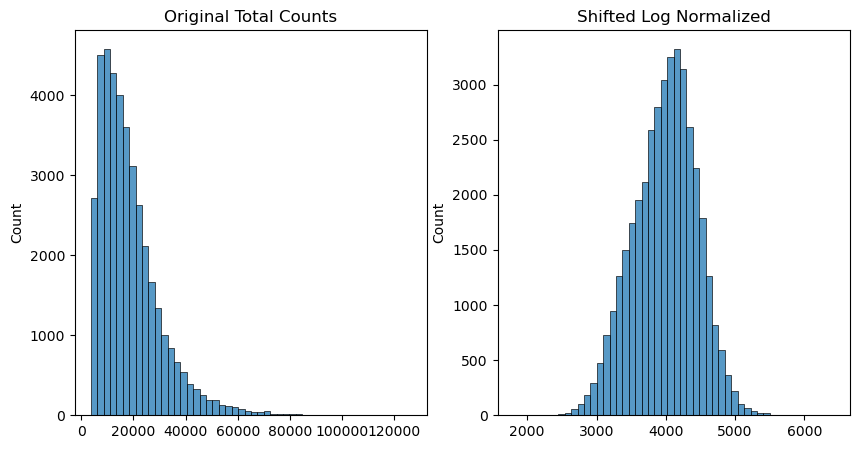

In [4]:
# 🔄 Total count normalization + log1p
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)

# 📊 Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Shifted Log Normalized")
plt.show()


## 7.3 Scran Normalization: Pseudo-cluster Preparation

Scran requires cells to be grouped into clusters. We use PCA and Leiden clustering to assign pseudo-groups that represent transcriptionally similar cells.


In [ ]:
# 🧪 Preprocessing for Scran
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="scran_groups")


## 7.4 Compute Scran Size Factors in R

We now compute size factors using the `scran` R package. These will be used to normalize UMI counts while accounting for technical effects like sequencing depth.


In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from scipy.sparse import issparse

pandas2ri.activate()

# Transpose counts matrix
data_mat = adata.X.T
if issparse(data_mat):
    data_mat = data_mat.tocsc().toarray()  # convert to dense if needed

# Send to R
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["scran_groups"]


### 🧬 R Cell: Call Scran
We use `computeSumFactors()` from the scran package to estimate size factors for each cell.


In [ ]:
%%R -o size_factors
library(scran)
library(SingleCellExperiment)
library(BiocParallel)

sce <- SingleCellExperiment(list(counts = data_mat))
size_factors <- sizeFactors(computeSumFactors(
  sce,
  clusters = input_groups,
  min.mean = 0.1,
  BPPARAM = MulticoreParam()
))


R[write to console]: 




Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'as.SimpleList' of mode 'function' was not found


RInterpreterError: Failed to parse and evaluate line 'library(scran)\nlibrary(SingleCellExperiment)\nlibrary(BiocParallel)\n\nsce <- SingleCellExperiment(list(counts = data_mat))\nsize_factors <- sizeFactors(computeSumFactors(\n  sce,\n  clusters = input_groups,\n  min.mean = 0.1,\n  BPPARAM = MulticoreParam()\n))\n'.
R error message: 'Error in get(as.character(FUN), mode = "function", envir = envir) : \n  object \'as.SimpleList\' of mode \'function\' was not found'

## 7.5 Apply Scran Normalization

We normalize each cell by its computed size factor and apply log(1 + x). We also visualize the difference in count distributions.


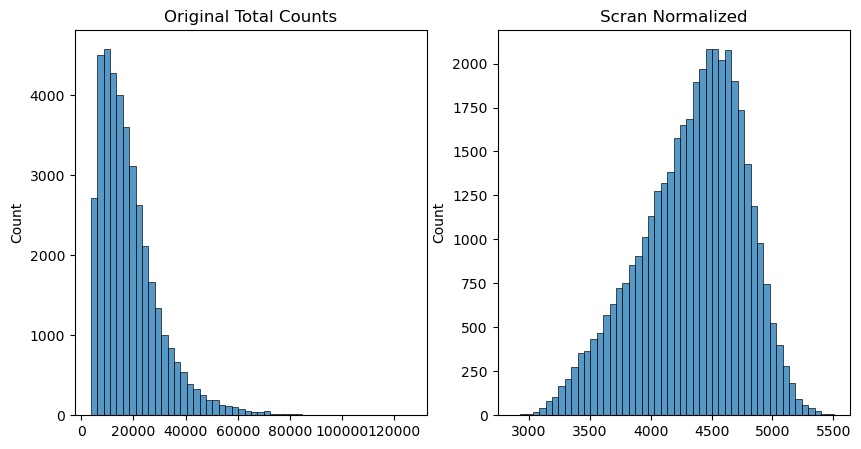

In [ ]:
# Apply scran normalization
adata.obs["size_factors"] = size_factors
scran_norm = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = np.log1p(scran_norm)

# 📊 Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["scran_normalization"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Scran Normalized")
plt.show()


In [ ]:
# 🧼 Ensure layers are in dense format if needed
from scipy.sparse import issparse
if issparse(adata.layers["scran_normalization"]):
    adata.layers["scran_normalization"] = adata.layers["scran_normalization"].tocsr()

# 💾 Save
adata.write("../../data/pancancer_normalized_all_layers.h5ad", compression="gzip")
print("✅ Saved all normalized layers to 'pancancer_normalized_all_layers.h5ad'")


## 7.6 Pearson Residual Normalization

Pearson residuals offer an analytical way to stabilize variance. This is useful for downstream clustering and visualization.


## 7.7 Save Normalized Dataset

We save the normalized AnnData object with all computed layers for future reuse.


In [ ]:
# 🧼 Ensure layers are in dense format if needed
from scipy.sparse import issparse
if issparse(adata.layers["scran_normalization"]):
    adata.layers["scran_normalization"] = adata.layers["scran_normalization"].tocsr()

# 💾 Save
adata.write("../../data/pancancer_normalized_all_layers.h5ad", compression="gzip")
print("✅ Saved all normalized layers to 'pancancer_normalized_all_layers.h5ad'")


NameError: name 'adata' is not defined